In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_bw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 16 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 32 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.014421939849853516
fw n match: False, max diff: 0.007791996002197266
fw m match: False, max diff: 0.0028891563415527344
fw D match: False, max diff: 0.0023733973503112793
---------------------------------
bw dQs match: False, max diff: 0.036190032958984375
bw dKs match: False, max diff: 0.0467529296875
bw dVs match: False, max diff: 0.010759830474853516
bw dIgs match: False, max diff: 0.01937389373779297
bw dFgs match: False, max diff: 0.005458354949951172
bw delta_D match: False, max diff: 0.09063720703125
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.07542181015014648
fw n match: False, max diff: 0.054708003997802734
fw m match: False, max diff: 0.022501468658447266
fw D match: False, max diff: 0.0102919340133667
---------------------------------
bw dQs match: False, max diff: 0.3012351989746094
bw dKs match: False, max diff: 0.3594970703125
bw dVs match: False, max diff: 0.059552669525146484
bw dIgs match: F

In [13]:
(matD_pt)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.486

In [14]:
(matD_pt_half)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1504e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3855e-01, 1.2683e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5542e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5664e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 7.9932e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.5034e-02, 3.2013e-02, 2.5293e-01, 6.3086e-01, 5.0391e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2330e-03, 2.9545e-03, 2.3376e-02, 5.8441e-02, 4.6600e-02, 9.2468e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2178e-03, 1.1177e-03, 8.8196e-03, 2.1881e-02, 1.7471e-02, 3.476

In [15]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

In [16]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [17]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [18]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [19]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [20]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.0754, device='cuda:0'), tensor(0.0061, device='cuda:0'))

### match directly

In [21]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 28096
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4


In [22]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 14336
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4


In [23]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 14336
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4


In [24]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.9073486328125e-06
fw n match: True, max diff: 1.1920928955078125e-06
fw m match: True, max diff: 8.940696716308594e-07
fw D match: False, max diff: 0.0
---------------------------------
bw dQs match: False, max diff: 78.61907196044922
bw dKs match: False, max diff: 104.00324249267578
bw dVs match: False, max diff: 98.86331176757812
bw dIgs match: True, max diff: 5.7220458984375e-05
bw dFgs match: True, max diff: 9.298324584960938e-06
====== Half ======
fw hs match: False, max diff: 0.0031490325927734375
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 0.0
---------------------------------
bw dQs match: False, max diff: 78.66182708740234
bw dKs match: False, max diff: 104.04918670654297
bw dVs match: False, max diff: 98.92823028564453
bw dIgs match: False, max diff: 0.01565074920654297
bw dFgs match: False, max diff: 0.00353431701660

In [25]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

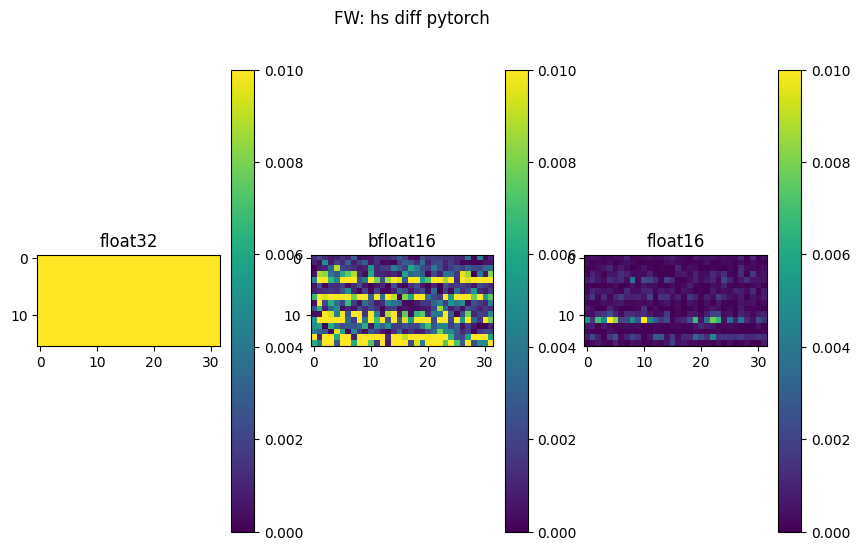

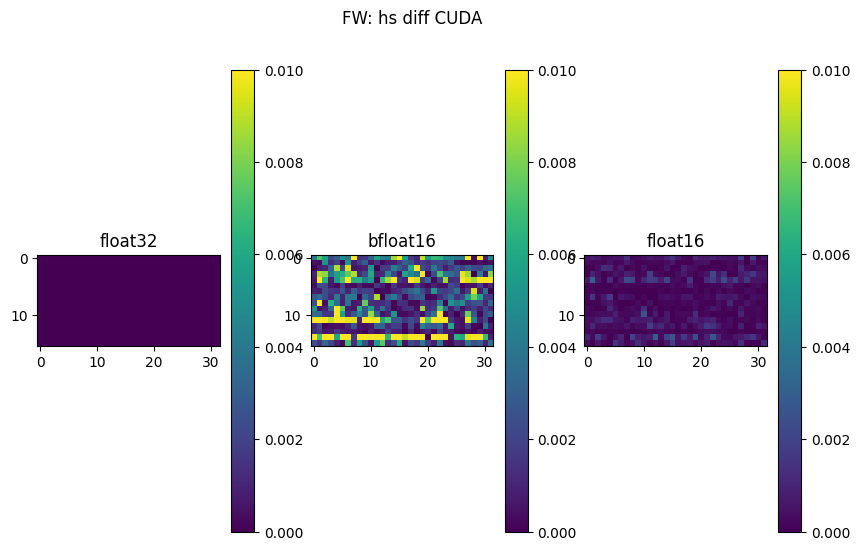

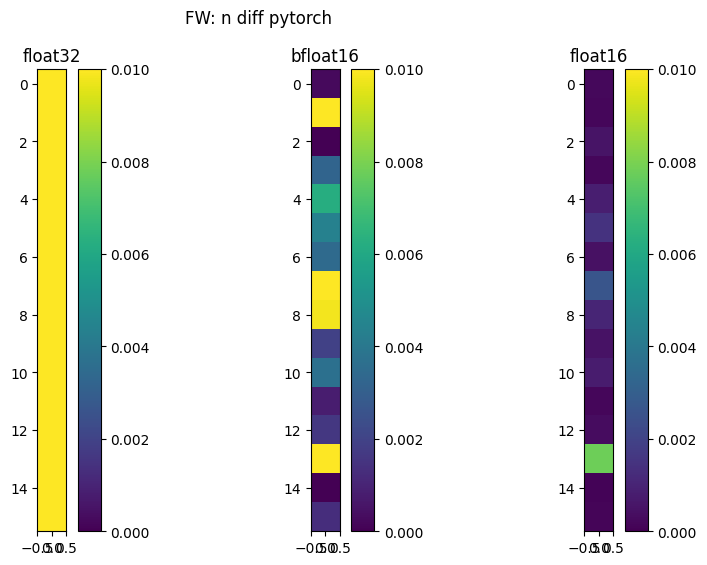

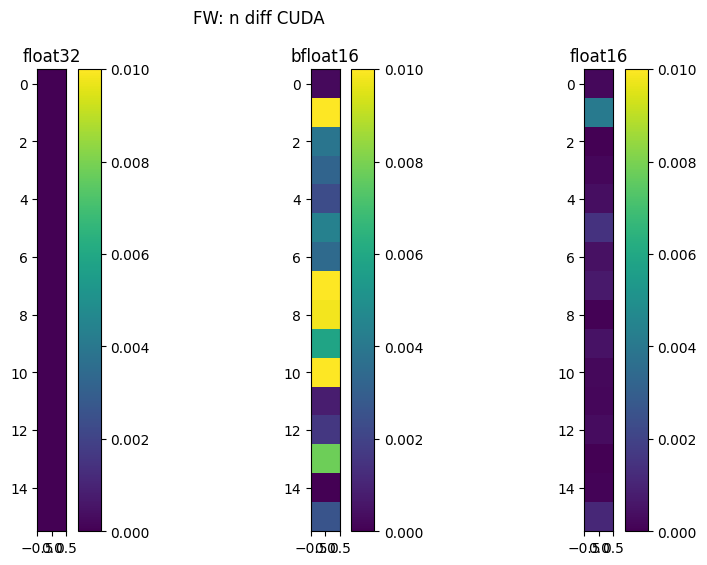

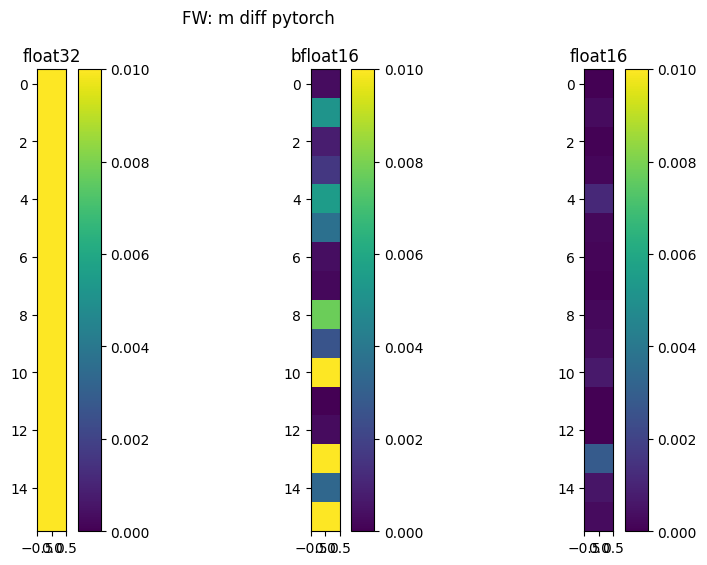

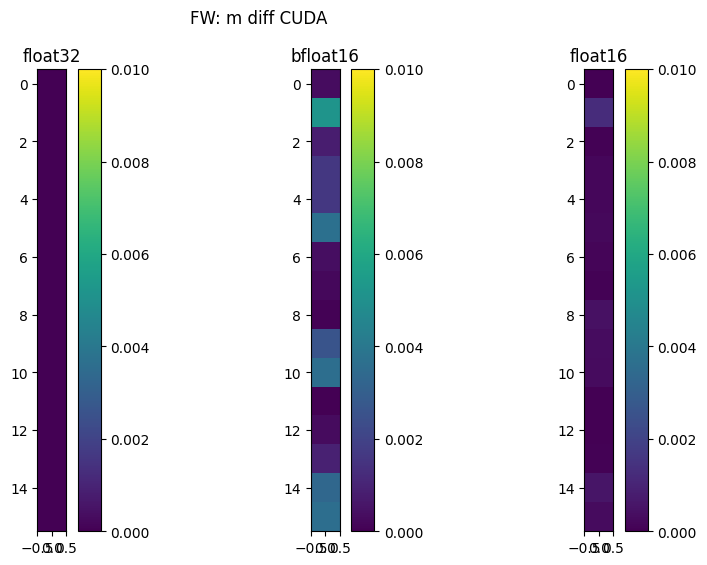

In [26]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

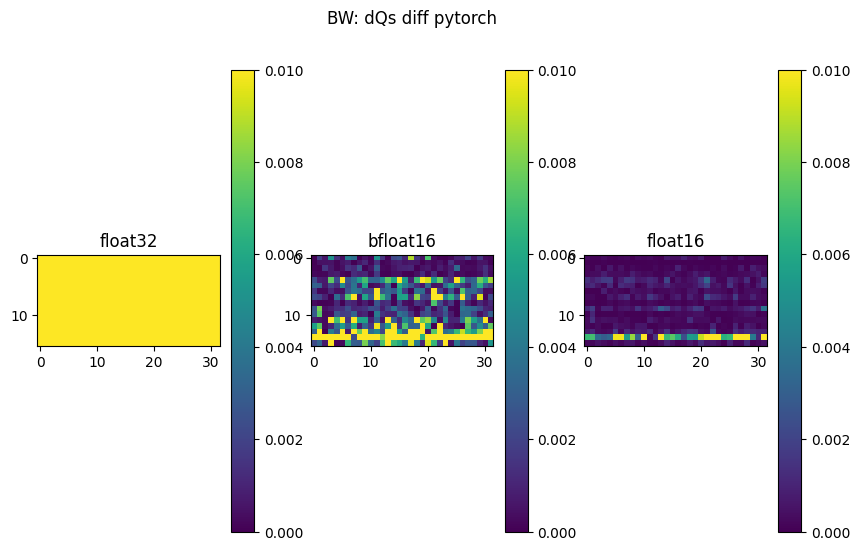

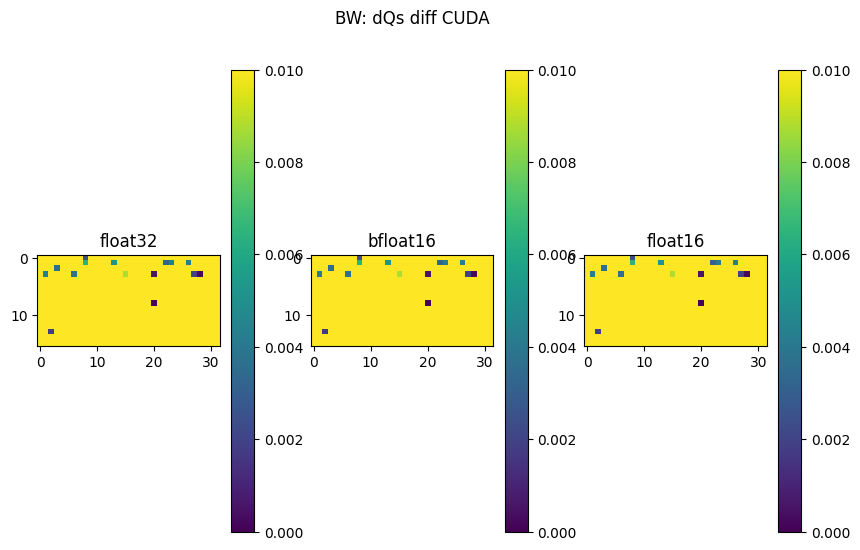

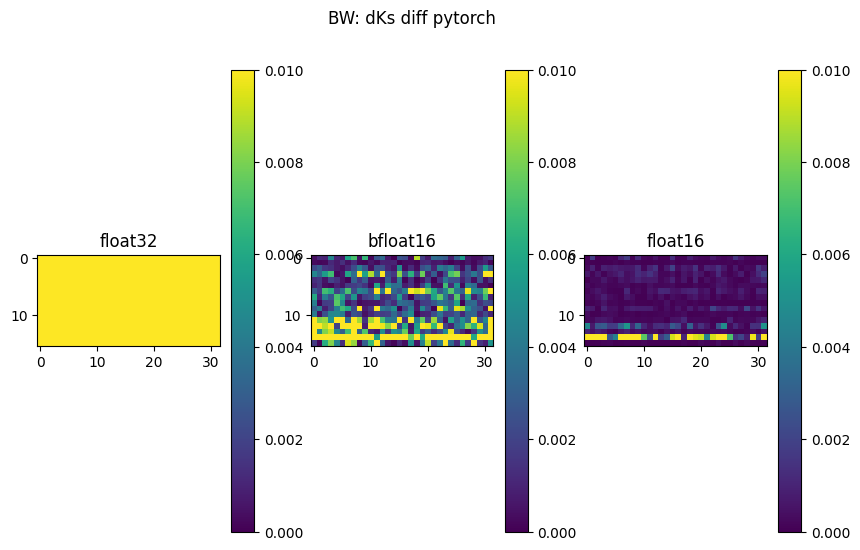

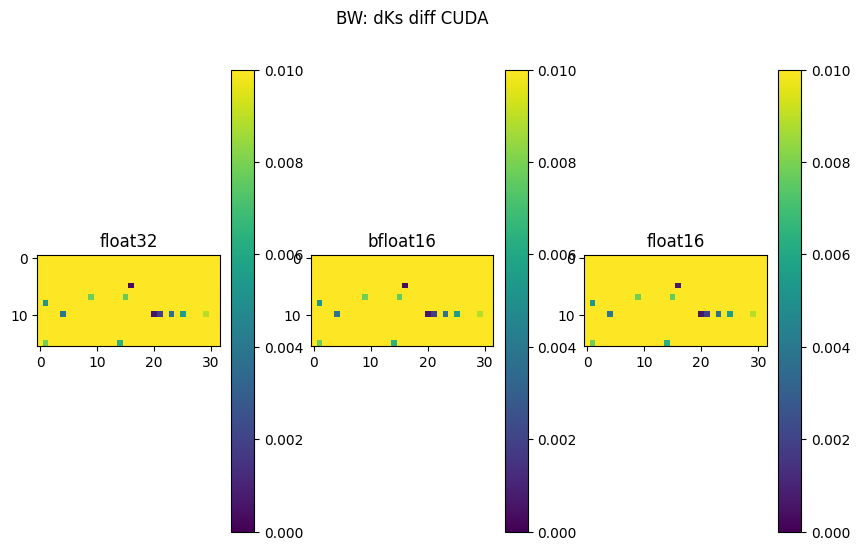

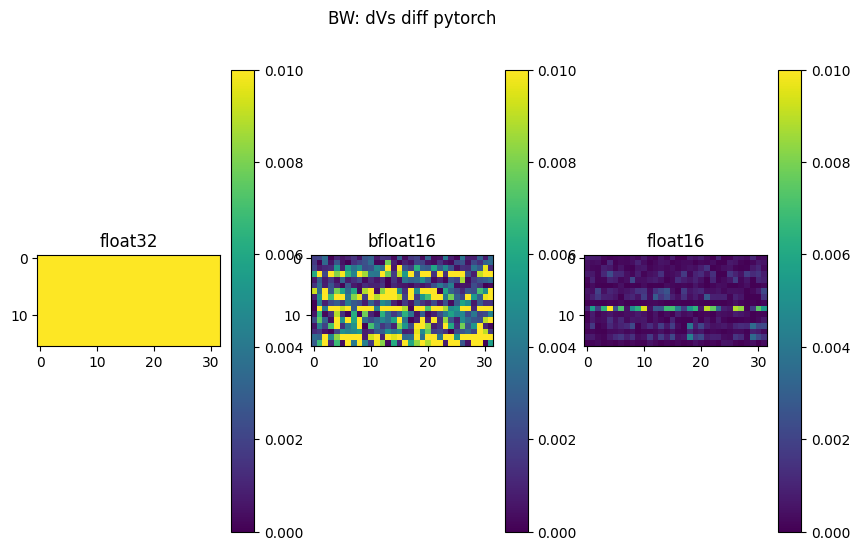

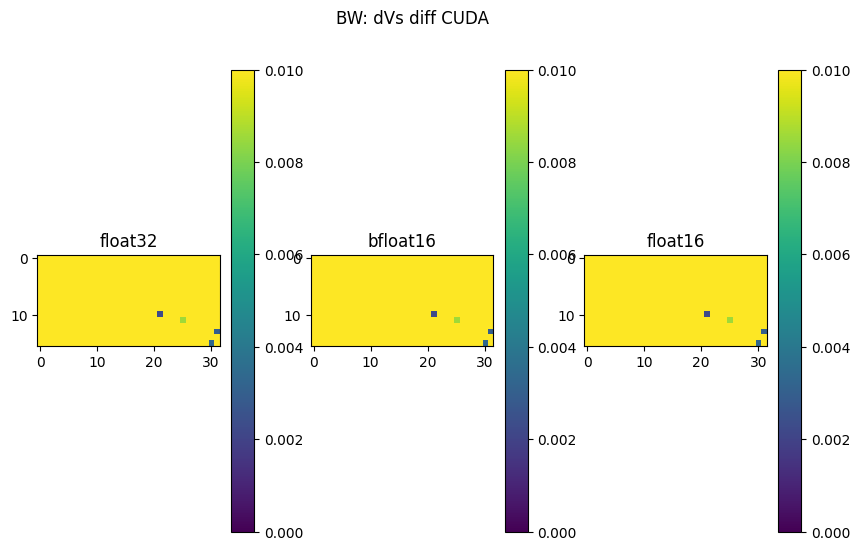

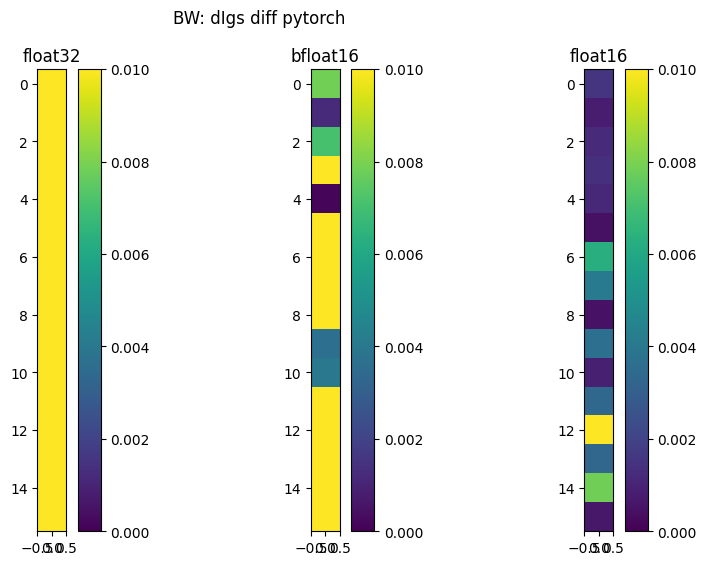

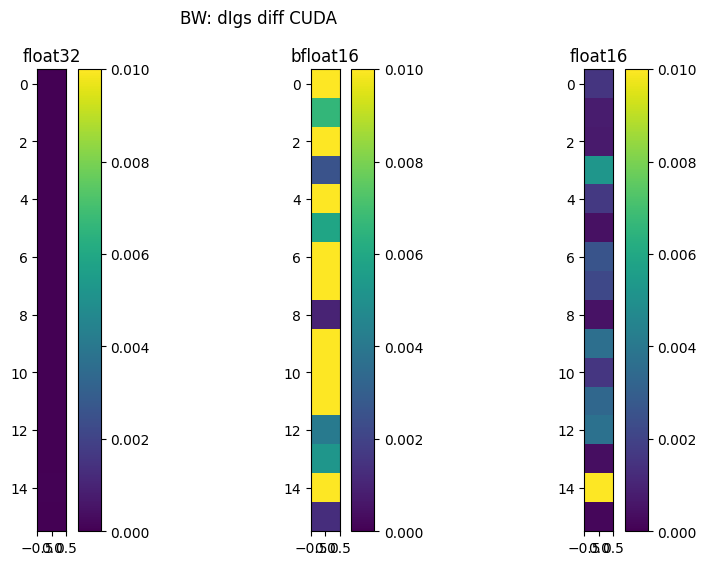

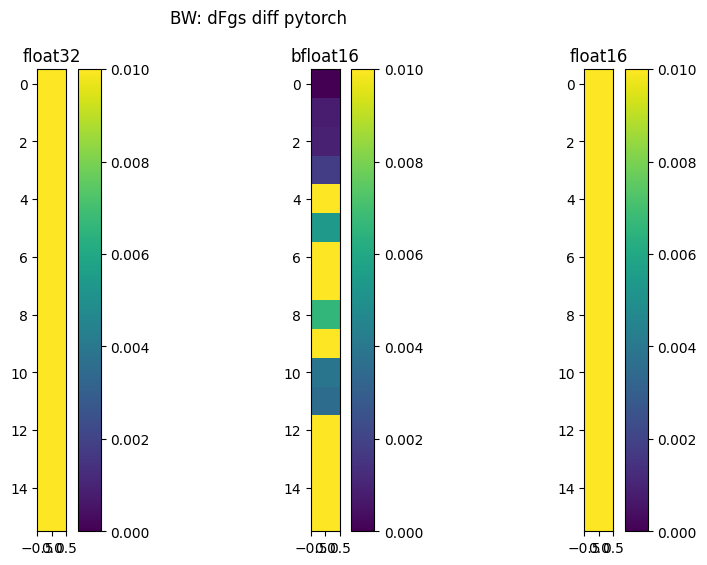

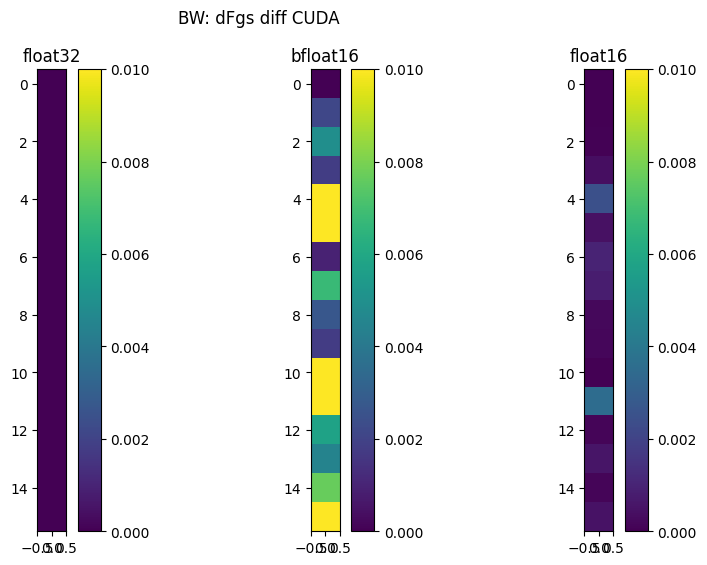

In [27]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [28]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [29]:
fgs

tensor([[[[-1.4286],
          [-1.0874],
          [ 0.5559],
          [ 1.0172],
          [-0.3479],
          [-1.3633],
          [-1.3168],
          [ 0.9415],
          [ 0.5776],
          [-0.4001],
          [-0.4550],
          [-0.5947],
          [-2.3788],
          [ 0.0537],
          [ 0.5271],
          [-0.2673]]]], device='cuda:0')

In [30]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [31]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: 0.0031490325927734375
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 0.0


In [32]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [33]:
# (matD_cu_half - matS)[:, :, :, :10]

In [34]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-1.6436],
          [-1.3779],
          [-0.4531],
          [-0.3086],
          [-0.8823],
          [-1.5908],
          [-1.5537],
          [-0.3293],
          [-0.4456],
          [-0.9131],
          [-0.9463],
          [-1.0342],
          [-2.4668],
          [-0.6665],
          [-0.4641],
          [-0.8359]]]], device='cuda:0', dtype=torch.float16)

In [35]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-1.6434],
          [-1.3779],
          [-0.4533],
          [-0.3087],
          [-0.8822],
          [-1.5911],
          [-1.5542],
          [-0.3293],
          [-0.4455],
          [-0.9131],
          [-0.9463],
          [-1.0341],
          [-2.4675],
          [-0.6667],
          [-0.4639],
          [-0.8357]]]], device='cuda:0')

In [36]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[0.1696,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
           [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   

### debug fw hs nans in last timesteps

In [37]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [38]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [39]:
hs_cu_half[:, :, 20:30, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10), dtype=torch.float16)

In [40]:
n_cu[:, :, 120:]

tensor([], device='cuda:0', size=(1, 1, 0, 1))

In [41]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10))

In [42]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.9073486328125e-06
fw n match: True, max diff: 1.1920928955078125e-06
fw m match: True, max diff: 8.940696716308594e-07
fw D match: False, max diff: 0.0


### debug fw hs for Q64xKV64

**Not working:** Possible reason for Q64xKV64 we use too much shared memory than available on the the laptop gpu.

In [43]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [44]:
(hs_cu - hs_pt)[:,:, :10, :10] 

tensor([[[[-5.2154e-08, -8.9407e-08,  7.4506e-08,  2.6077e-08,  4.4703e-08,  6.7055e-08, -5.2154e-08,  1.6391e-07,  1.6764e-08,  2.2352e-08],
          [-3.7253e-08,  2.9802e-08, -2.3842e-07,  4.4703e-08,  7.4506e-08, -5.9605e-08,  1.7881e-07, -2.9802e-08,  8.9407e-08, -1.1921e-07],
          [ 1.4901e-08,  1.1176e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1921e-07, -1.1921e-07,  0.0000e+00,  1.1921e-07,  0.0000e+00, -1.1921e-07,  0.0000e+00],
          [-5.9605e-08, -7.1526e-07, -4.7684e-07, -1.1921e-07,  1.0268e-07,  3.5763e-07,  3.5763e-07,  7.1526e-07, -5.9605e-08, -1.1921e-07],
          [ 4.8429e-08,  1.1921e-07,  1.4901e-07,  1.4901e-07,  2.9802e-08, -2.3842e-07, -8.9407e-08, -1.5646e-07,  8.9407e-08,  0.0000e+00],
          [-1.4901e-08,  1.1921e-07,  4.4703e-08, -1.4901e-08, -5.9605e-08,  5.9605e-08,  0.0000e+00, -1.7881e-07, -1.1921e-07,  5.9605e-08],
      

In [45]:
(hs_cu)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [46]:
(hs_pt)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [47]:
(matD_cu - matD_pt)[:,:, :10, :10] 

tensor([[[[-0.8304,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,

In [48]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.9073486328125e-06
fw n match: True, max diff: 1.1920928955078125e-06
fw m match: True, max diff: 8.940696716308594e-07
fw D match: False, max diff: 0.0


In [49]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[-0.4355,  0.7339,  0.2881, -0.2800,  0.0191,  1.7305, -0.0679, -0.3425,  0.3208, -0.0308],
          [-0.5664, -1.7983,  0.0303,  0.3872,  0.5479,  0.6392, -0.6567, -0.1105,  0.3560, -0.2363],
          [-0.2902, -0.4161, -1.8354,  0.6147, -0.1220, -0.2294, -0.6074, -0.0473, -1.0947,  0.9653],
          [ 0.3219,  0.4335,  0.1851, -2.0947,  0.1971,  0.8569,  1.3711, -0.4600,  0.2642, -0.2106],
          [ 0.1092,  0.2145, -0.2040, -1.1606, -0.7641,  0.5039,  0.0686, -0.1092,  0.2351, -0.1556],
          [ 0.0279, -0.3159, -0.3209, -0.3663, -0.3827, -0.9327, -0.3804,  0.0352,  0.0769, -0.0347],
          [-0.0500, -0.0168, -0.2027,  0.0302, -0.0660, -0.1262, -1.1039, -0.0184, -0.1951,  0.1300],
          [ 0.0646,  0.1114,  0.1042, -0.2424,  0.0095,  0.1155, -0.0969, -1.0834,  0.0443, -0.0404],
          [ 0.0209,  0.0620,  0.0613, -0.0921, -0.0021,  0.0421, -0.3257, -1.0134, -0.4554, -0.1024],
          [-0.0210, -0.0584, -0.0473,  0.0988, -0.0035, -0.0537, -0.1642, -0.0569,

In [50]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [51]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

### debug q16xkv16 tile size backward

In [52]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
seqLen must be divisible by QblockDim and KVblockDim
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 28096
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4


In [53]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.9073486328125e-06
fw n match: True, max diff: 1.1920928955078125e-06
fw m match: True, max diff: 8.940696716308594e-07
fw D match: False, max diff: 14.183614730834961
---------------------------------
bw dQs match: False, max diff: 78.61907196044922
bw dKs match: False, max diff: 104.00324249267578
bw dVs match: False, max diff: 98.86331176757812
bw dIgs match: True, max diff: 5.7220458984375e-05
bw dFgs match: True, max diff: 9.298324584960938e-06


In [54]:
# dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt

In [59]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)

In [60]:
(matC_cu-matS)[:, :, -20:, :10], torch.abs((matC_cu-matS)).max()

(tensor([[[[-6.7055e-08,  4.7684e-07, -2.3842e-07,  2.3842e-07,  5.9605e-08, -5.9605e-08,  5.9605e-08, -1.1921e-07,  2.3842e-07,  0.0000e+00],
           [-1.1921e-07, -1.1921e-07,  1.7881e-07, -1.1921e-07, -4.7684e-07, -2.9802e-08,  2.3842e-07,  4.4703e-08,  1.1921e-07,  0.0000e+00],
           [ 8.9407e-08,  5.9605e-08, -5.9605e-08, -5.9605e-08,  5.9605e-08,  1.1921e-07, -1.7881e-07,  0.0000e+00, -3.5763e-07,  0.0000e+00],
           [-2.3842e-07,  2.9802e-07, -1.1921e-07,  0.0000e+00,  0.0000e+00,  1.1921e-07, -1.1921e-07,  2.0862e-07,  4.7684e-07, -2.3842e-07],
           [ 1.7881e-07, -1.1921e-07,  0.0000e+00,  0.0000e+00, -1.1921e-07,  1.1921e-07,  3.7253e-08, -2.3842e-07, -1.0431e-07, -5.9605e-08],
           [-1.1921e-07, -7.4506e-08,  2.9802e-08, -4.4703e-08, -1.1921e-07, -1.1921e-07,  1.1921e-07, -1.5646e-07,  5.9605e-08,  1.1921e-07],
           [ 2.0862e-07, -1.7881e-07,  1.4901e-08,  0.0000e+00,  1.4901e-08,  1.1921e-07, -5.9605e-08,  2.9802e-08, -1.1921e-07,  8.9407e-08],

In [55]:
(matC_cu-delta_Dtilde_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_Dtilde_pt)).max()

(tensor([[[[ 0.2558, -1.8711,  0.9341, -1.3155, -0.9150, -0.4050, -0.7507,  1.6704, -1.1101, -0.4790],
           [ 0.4633,  0.9531, -0.6924,  1.2197,  2.2210,  0.3152, -1.7155,  0.0756, -1.8405,  0.3306],
           [-0.2985, -0.3295,  3.8469,  0.7662, -0.7581, -1.7819,  0.9815, -0.8251,  1.2308,  0.7307],
           [ 1.7453, -0.2865, -0.4067,  0.6975, -0.8449, -1.0497,  1.2888, -0.3716,  1.6619, -1.0586],
           [-0.8435,  1.2286,  0.3997, -7.0410, -0.0186, -1.1140, -0.1066,  0.7551,  0.1469,  0.9564],
           [ 1.4053, -0.1838, -0.8170, -0.0449,  2.6560, -2.0254,  0.8315,  0.1133,  0.5467, -1.3158],
           [ 0.4703,  0.2148,  0.2760,  3.1347, -0.3379,  2.7090, -1.6114, -0.2174,  0.1944,  0.3227],
           [-1.1498, -1.6572, -0.2421, -0.5072, -1.5563, -1.1117,  0.0635,  5.1019, -1.2404, -1.2537],
           [-0.4952, -1.5009, -0.1277,  0.4224, -0.3621,  0.6763, -1.0489, -1.1339, -1.4700, -2.1258],
           [ 0.5131,  0.7715,  0.0528, -0.3957, -0.4382, -0.3082,  0.4213

In [56]:
(matC_cu-delta_D_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_D_pt)).max()

(tensor([[[[ 2.5576e-01, -8.7125e+00, -7.2211e+00,  1.1505e+01, -7.9108e+00,  2.6337e+00,  3.2143e+00, -1.5375e+00,  9.4367e+00,  2.3326e+00],
           [ 4.6326e-01,  9.5535e-01, -1.1859e+00,  1.0172e+00, -1.5053e+00,  5.6536e-01,  4.9033e+00,  6.7435e-02,  1.7235e-01,  1.9541e-01],
           [-9.0366e-01,  3.3478e+00,  3.8469e+00, -1.4710e+00,  1.0786e+01, -2.6861e+01, -8.3775e-01, -2.3748e+00, -1.1833e+00, -3.6477e+00],
           [ 4.4645e+00,  6.8657e+00,  6.8079e-02,  6.9755e-01,  9.8271e+00, -1.3176e+01, -8.6354e+00,  3.6037e+00, -1.6537e+01,  9.0512e+00],
           [-2.1782e+00,  9.0154e-01,  1.4039e+00, -7.0410e+00, -2.7417e-01, -1.1080e+01, -7.4868e-02,  7.5192e-01,  8.4849e-01,  5.7552e+00],
           [ 1.0738e+00,  7.6593e-02, -1.7959e+00, -2.1022e-01,  4.4612e+00, -2.0254e+00,  1.5728e+00, -2.5302e-01, -1.3435e+00, -2.0097e+00],
           [ 1.7108e+00, -2.2330e+00,  1.6645e+00,  1.6438e+01, -2.2134e+00,  1.3879e+01, -1.6114e+00, -5.6095e-01,  1.0876e+00, -4.8423e-01],

In [57]:
(matC_cu-matD_pt)[:, :, :20, :10]

tensor([[[[-1.0961, -1.8711,  0.9341, -1.3155, -0.9150, -0.4050, -0.7507,  1.6704, -1.1101, -0.4790],
          [-0.3490,  0.0128, -0.6924,  1.2197,  2.2210,  0.3152, -1.7155,  0.0756, -1.8405,  0.3306],
          [-0.3397, -0.9903, -0.0775,  0.7662, -0.7581, -1.7819,  0.9815, -0.8251,  1.2308,  0.7307],
          [ 1.5296, -0.7208, -1.1262, -0.0177, -0.8449, -1.0497,  1.2888, -0.3716,  1.6619, -1.0586],
          [-0.8205,  1.1953, -0.6748, -2.1995,  0.2052, -1.1140, -0.1066,  0.7551,  0.1469,  0.9564],
          [ 1.3824, -0.2244, -0.7389, -0.3935,  0.3242, -1.7731,  0.8315,  0.1133,  0.5467, -1.3158],
          [ 0.4630,  0.2191,  0.2195,  2.2550, -0.2929,  1.4781, -1.5495, -0.2174,  0.1944,  0.3227],
          [-1.1496, -1.6560, -0.2492, -0.5493, -1.5851, -1.0431, -1.8645,  1.6845, -1.2404, -1.2537],
          [-0.4982, -1.5032, -0.1383,  0.3742, -0.3735,  0.6294, -1.2374, -1.9321, -1.3999, -2.1258],
          [ 0.5129,  0.7712,  0.0519, -0.4028, -0.4377, -0.3196,  0.3388,  0.2165,

In [58]:
(dQs_cu - dQs_pt)[:,:,:10, :10]

tensor([[[[ 4.1022e-01,  4.1614e-01,  4.1541e-01,  9.3634e-01, -2.8773e-01,  3.9293e-01,  5.7394e-01,  6.1358e-01,  2.3575e-03,  2.9742e-01],
          [ 3.0701e-02,  3.4206e-02,  3.6137e-02,  6.9303e-02, -2.1695e-02,  3.4136e-02,  4.8496e-02,  4.1051e-02,  6.3953e-03,  3.4514e-02],
          [ 1.2462e-01, -9.7131e-02, -8.8828e-01, -3.6399e-03, -8.2797e-01, -1.4901e-01, -6.2649e-01,  4.7380e-01,  5.1686e-01, -5.3136e-01],
          [-2.3341e-02,  4.2421e-03,  1.5916e-02,  1.8490e-01,  1.0909e-01, -3.0434e-02,  3.7813e-03,  1.4035e-01, -3.2136e-01, -1.6807e-01],
          [ 6.5174e-01, -9.7425e-01, -6.8626e-01, -2.6490e+00, -9.7838e-01, -1.0582e+00, -9.2889e-01, -8.2869e-01,  2.7922e+00, -1.2308e+00],
          [ 1.3638e+00, -9.2142e-01, -2.5736e-02,  2.3452e+00,  8.4125e-01,  9.3961e-01, -2.2436e+00,  8.2872e-01, -2.7347e-01,  9.2233e-01],
          [-4.6414e-01, -4.5961e-01, -4.1925e-01, -9.8388e-01,  3.3034e-01, -4.2896e-01, -3.9230e-01, -1.0563e+00,  3.7038e-01, -4.2325e-01],
      